In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.ndimage import sobel

### Load the image and view the whole thing

In [2]:
IMAGE_FILE = '/home/spotter/data/dic/high_constrast/HC Reference.tif'

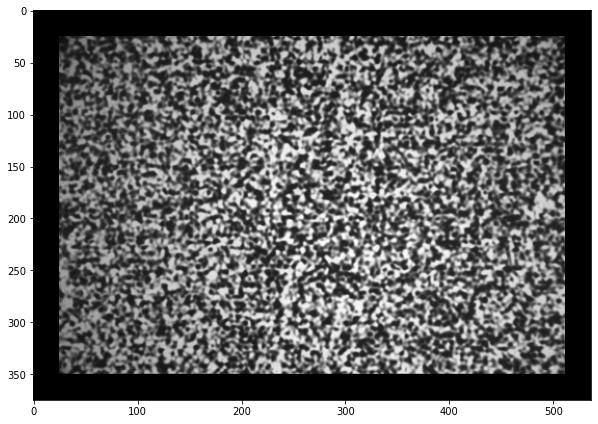

In [3]:
def_image = np.array(Image.open(IMAGE_FILE))
# Pad the image a bit so we can artificially deform it
def_image = np.pad(def_image, ((25, 25), (25, 25)))
fig = plt.figure(figsize=(10, 20))
plt.imshow(def_image, cmap='gray')
plt.show()

### Define image interpolation junk

In [4]:
# Why?? Maybe just use scipy.interpolate instead??

from scipy.interpolate import RectBivariateSpline

class ImageInterpolator:
    def __init__(self, image):
        self.image = image
        self.dx = None
        self.dy = None
        self.dxy = None
        self._coefficient_cache = {}
        
    def interpolate(self, row, column):
        # FIXME -- need better names
        xmin = int(np.floor(column))
        x = column - xmin
        ymin = int(np.floor(row))
        y = row - ymin
        
        if None in (self.dx, self.dy, self.dxy):
            self._compute_sobel()
            
        key = f'row{ymin}col{xmin}'
        
        coeffs = self._coefficient_cache.get(key, None)
        
        if coeffs is None:
            coeffs = self._compute_bicubic_coeffs(xmin, ymin)
            self._coefficient_cache[key] = coeffs
        
        xs = np.array([1, x, x**2, x**3])
        ys = np.array([1, y, y**2, y**3])
        
        return xs.dot(coeffs.dot(ys))
        
            
    def _compute_bicubic_coeffs(self, col, row):
        """
        (0, 1) x ------ x (1, 1)
               |        |
               |        |
               |        |
        (0, 0) x ------ x (1, 0)
        """
        # FIXME - Cache these in class instantiation
        
        C = np.array([[1, 0, 0, 0],
                      [0, 0, 1, 0],
                      [-3, 3, -2, -1],
                      [2, -2, 1, 1]], dtype=float)
    
        D = np.array([[1., 0., -3., 2.],
                      [0., 0., 3., -2.],
                      [0., 1., -2., 1.],
                      [0., 0., -1., 1.]])
        
        col_slice = slice(col, col + 2, 1)
        row_slice = slice(row, row + 2, 1)
        
        F = np.zeros((4, 4))
        # Deal with image axis
        # FIXME -- need to deal with images being floats
        F[:2, :2] = np.flipud(self.image[row_slice, col_slice])
        F[2:, :2] = np.flipud(self.dy[row_slice, col_slice])
        F[:2, 2:] = np.flipud(self.dx[row_slice, col_slice])
        F[2:, 2:] = np.flipud(self.dxy[row_slice, col_slice])
        
        coeffs = C @ F @ D
        
        return coeffs        
            
    def _compute_sobel(self):
        self.dx = sobel(self.image, axis=0, mode='constant')
        self.dy = sobel(self.image, axis=1, mode='constant')
        self.dxy = sobel(self.dy, axis=0, mode='constant')
        
        
class ImageInterpolator:
    def __init__(self, image):
        # XXX: Flipping this correctly?
        xs = np.arange(image.shape[1])
        ys = np.arange(image.shape[0])
        self.spline = RectBivariateSpline(ys, xs, image)
        
    def interpolate(self, x, y):
        return self.spline(x, y, grid=False)
        

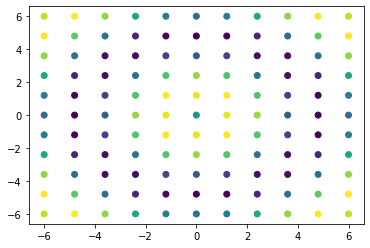

In [5]:
# Do a synthetic test
def f(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))

x = np.linspace(-6, 6, 11)
y = np.linspace(-6, 6, 11)

xs, ys = np.meshgrid(x, y)
ys = np.flipud(ys)  # Y positive down

z = f(xs, ys)

plt.scatter(xs, ys, c=z);

In [6]:
interpolator = ImageInterpolator(z)

def find_x(col):
    idx = int(np.floor(col))
    return xs[0, idx] + (col - idx) * (xs[0, idx + 1] - xs[0, idx])

def find_y(row):
    idx = int(np.floor(row))
    return ys[idx, 0] - (row - idx) * (ys[idx, 0] - ys[idx + 1, 0])

row, col = 1., 1.
x, y = find_x(col), find_y(row)
interpolated = interpolator.interpolate(row, col)

print(f'x: {x}')
print(f'y: {y}')
print(f'z: {f(x, y)}')
print(f'interpolated: {interpolated}')

x: -4.8
y: 4.799999999999999
z: 0.4838422650684992
interpolated: 0.48384226506849953


### Now make a synthetic reference image

In [13]:
rows = np.arange(def_image.shape[0])
columns = np.arange(def_image.shape[1])

xs, ys = np.meshgrid(columns, rows)

forward_grad = np.array([[1.05, 0], [0, 1.05]])

new_points = forward_grad @ np.column_stack([xs.ravel(), ys.ravel()]).T

interpolator = ImageInterpolator(def_image)
new_ys, new_xs = new_points[0], new_points[1]
ref_data = interpolator.interpolate(new_xs, new_ys)

In [14]:
ref_image = ref_data.reshape(def_image.shape)

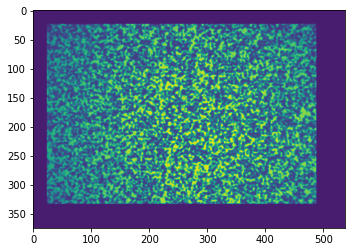

In [15]:
plt.imshow(ref_image)

In [10]:
new_points

array([[  0.        ,   0.95238095,   1.9047619 , ..., 508.57142857,
        509.52380952, 510.47619048],
       [  0.        ,   0.        ,   0.        , ..., 356.19047619,
        356.19047619, 356.19047619]])

In [11]:
ref_image.shape

(375, 537)

In [12]:
def_image.shape

(375, 537)